# Setup

In [70]:
%matplotlib inline
from pylab import *

import detectorgeometry_trap as geom_trap
reload(geom_trap)

import decay_properties as decay
reload(decay)

<module 'decay_properties' from 'decay_properties.py'>

In [55]:
# example data input to class to determine effective area
theta_src = radians(8) #radians
h = 35.5 #km
R = 6356. # km
ice =4
theta_view = radians(1) #degrees
N = 500 # number of samples
E_nu = 19 #log energy in eV of incident neutrino 
E_cut = 14

geom_area = geom_trap.Area(theta_src,h,R,theta_view, N)
A_deg, phi_e, theta_e, view_angle, exit_angle, norm, e_dot = geom_area.event_retention()
print A_deg

1.2102545398986198


In [56]:
# Assign to each event a tau energy, tau decay point, a decay probability, calculated view angle
# inputs : theta_src, ice, E_cut, e_dot, phi_e, t_e, rho, E_nu,h,R,view_cut, exit_angles
decay1 = decay.tau_event(theta_src, ice, E_cut, e_dot, phi_e, theta_e, norm,E_nu, h, R, theta_view, exit_angle, A_deg)
                        

In [32]:
print decay1.E_tau()


!!!! WARNING !!!!
len(self.data_array[data_index])= 1
self.data_array[data_index] =  [15.15829]
returning self.data_array[data_index][0] =  15.15829

!!!! WARNING !!!!
len(self.data_array[data_index])= 1
self.data_array[data_index] =  [15.15829]
returning self.data_array[data_index][0] =  15.15829

!!!! WARNING !!!!
len(self.data_array[data_index])= 1
self.data_array[data_index] =  [15.15829]
returning self.data_array[data_index][0] =  15.15829

!!!! WARNING !!!!
len(self.data_array[data_index])= 1
self.data_array[data_index] =  [15.15829]
returning self.data_array[data_index][0] =  15.15829

!!!! WARNING !!!!
len(self.data_array[data_index])= 1
self.data_array[data_index] =  [15.15829]
returning self.data_array[data_index][0] =  15.15829

!!!! WARNING !!!!
len(self.data_array[data_index])= 1
self.data_array[data_index] =  [15.15829]
returning self.data_array[data_index][0] =  15.15829

!!!! WARNING !!!!
len(self.data_array[data_index])= 1
self.data_array[data_index] =  [15.15829]
ret

In [33]:
print decay1.P_exit(exit_angle)

[0.0, 0.0, 0.0, 0.0, 0.0, 3.007583052500238e-08, 0.0, 8.570812551427883e-08, 3.2186785655690544e-08, 6.13838294969402e-08, 7.32053225127744e-08, 0.0, 4.23117500977483e-08, 6.09868308595503e-08]


In [ ]:
ret_e_dot, ret_phi_e, ret_t_e, ret_tau_energy, ret_decay_dist, ret_view_angle, ret_fractions,ret_types = decay1.event_retention()
print ret_e_dot
print ret_phi_e
print ret_t_e
print ret_tau_energy
print ret_decay_dist
print ret_view_angle
print ret_fractions
print ret_types

In [71]:
h = 37 #km
R = 6356. # km
theta_view = radians(1) #degrees
N = 100000 # number of samples
E_nu = 19 #log energy in eV of incident neutrino 
E_cut = 14
ice=4

# Creating a plot for the full range of possible source declinations 
start = 0 # minimum source declination in degrees
end = 90 # maximum source declination in degrees
steps=90 # divisions indeclination used to generate plot
x1 = np.linspace(-end,-start,steps)

A_g = []
A_P_exit = []
theta_view = radians(1)
for j in range(0,steps):
    print j
    theta = radians(start+(end-start)*float(j)/steps)
    geom_area = geom_trap.Area(theta,h,R,theta_view, N)
    geomA, phi_e, theta_e, view_angle, exit_angle, norm, e_dot = geom_area.event_retention()
    print geomA
    decay_sim = decay.tau_event(theta, ice, E_cut, e_dot, phi_e, theta_e, norm,E_nu, h, R, theta_view, exit_angle, geomA)
    A_PE = decay_sim.degree_eff_area()
    
    A_g.append(geomA)
    A_P_exit.append(A_PE)
    print A_PE



0
1.3076393776874555
0.0
1
1.306910941826377
0.0
2
1.3045883439470911
0.0
3
1.28575639949266
0.0
4
1.341820065129769
0.0
5
1.322586838392584
2.2099503093651255e-08
6
1.3507761227275714
0.00010651043753950027
7
1.3334470476534328
0.00020912351528796927
8
1.3496144763208155
6.098892940772311e-05
9
1.3669870766082164
0.0
10
1.336729653387523
0.0
11
1.357246353591369
0.0
12
1.4060710569204284
0.0
13
1.3937664258721083
0.0
14
1.4379112689303317
0.0
15
1.3468073850175486
1.2075476756726734e-07
16
1.4404229268213542
4.6636115429872616e-05
17
1.4449803584698593
9.106230895955525e-05
18
1.38783459520137
2.3494643017184863e-05
19
1.5163574452050104
4.331795515644159e-05
20
1.4641940683551136
7.72899809337006e-05
21
1.4644094064282016
1.782269010852039e-05
22
1.5166633621494932
0.0
23
1.4885846703551022
2.7298625169658255e-07
24
1.5396037707360026
3.61764471888947e-05
25
1.6312167823816515
0.00010536257828824932
26
1.6085656915648416
7.763891690208435e-05
27
1.693017201915762
1.437806871796957e-0

In [67]:
h = 37 #km
R = 6356. # km
theta_view = radians(1) #degrees
N = 100000 # number of samples
E_nu = 19 #log energy in eV of incident neutrino 
E_cut = 14
ice=4

# Creating a plot for the full range of possible source declinations 
start = 0 # minimum source declination in degrees
end = 90 # maximum source declination in degrees
steps=90 # divisions indeclination used to generate plot
x1 = np.linspace(-end,-start,steps)

A_P_exit_energy_decay = []
theta_view = radians(1)
for j in range(0,steps):
    print j
    theta = radians(start+(end-start)*float(j)/steps)
    geom_area = geom_trap.Area(theta,h,R,theta_view, N)
    geomA, phi_e, theta_e, view_angle, exit_angle, norm, e_dot = geom_area.event_retention()
    decay_sim = decay.tau_event(theta, ice, E_cut, e_dot, phi_e, theta_e, norm,E_nu, h, R, theta_view, exit_angle, geomA)
    A_PE_energy_decay = decay_sim.degree_eff_area()
    
    A_P_exit_energy_decay.append(A_PE_energy_decay)



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89


[]

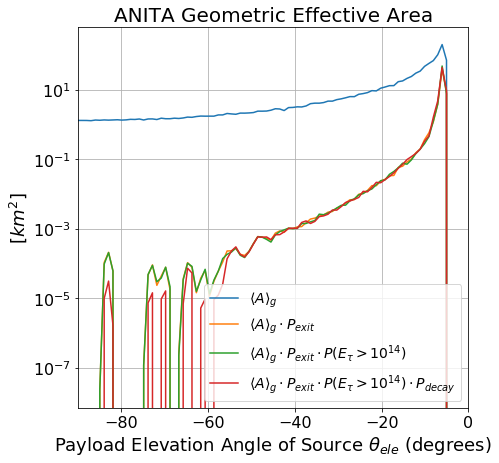

In [72]:
fig = plt.figure(figsize=(7,7))
ax = plt.axes()

ax.plot(x1, A_g)
ax.plot(x1, A_P_exit)
ax.plot(x1, A_P_exit_energy)
ax.plot(x1, A_P_exit_energy_decay)
    
#plt.fill_between(x2, sky_maps[0],sky_maps[1],color='tab:gray')
horizon = degrees(np.arcsin(R / (R+h)))-90
plt.xlim(-90,0)  
legend = ax.legend([r'$\langle A \rangle_g$', r'$\langle A \rangle_g \cdot P_{exit}$', r'$\langle A \rangle_g \cdot P_{exit} \cdot P(E_\tau > 10^{14})$', r'$\langle A \rangle_g \cdot P_{exit} \cdot P(E_\tau > 10^{14}) \cdot P_{decay}$'], fontsize=14)
plt.xlabel("Payload Elevation Angle of Source "+r'$\theta_{ele}$'+" (degrees)", fontsize=18)
plt.ylabel(r'$[km^2]$', fontsize=18)
plt.title("ANITA Geometric Effective Area", fontsize=20)
plt.setp(legend.get_title(),fontsize='x-large')
ax.tick_params(axis = 'both', which = 'major', labelsize = 16)
plt.grid(True,which='both')
plt.semilogy()

## Adding RF cuts

In [ ]:
import sys
sys.path.append('nutau_sim/03_Detector')
sys.path.append('nutau_sim/applications/ANITA_upper_bound')
import tau_Shower_Efield_ANITA_Sim_lib  as RF

In [ ]:
geom_file_name ='geom_outputs/geom_37_km_5_deg_10M_ev.npz'
LUT_file_name ='./high_statistics/'+decay1.ice+'km_ice_midCS_stdEL/LUT_'+decay1.TEScall+'_eV.npz'
EFIELD_LUT_file_name = 
cut_ang = degrees(theta_view)
f_Lo =
f_High = 

In [ ]:
# need probability of trigger
RF.A_OMEGA_tau_exit(geom_file_name, LUT_file_name, EFIELD_LUT_file_name, cut_ang, f_Lo, f_High, outTag='test', 
			N=-1, noise='default', Gain_dB=10.0, Nphased=1, LUT=False, icethick_geom = 4.0, 
			Epk_to_pk_threshold = 284e-6, Max_Delta_Theta_View = 4.0 )